In [ ]:
import pandas as pd
try:
    df = pd.read_csv('TCS.csv')
    print("File loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure 'TCS.csv' is in the same folder as your script.")


df['Date'] = pd.to_datetime(df['Date'])


df.set_index('Date', inplace=True)

print("\nFirst 5 rows with Date as index:")
print(df.head())

File loaded successfully!

First 5 rows with Date as index:
           Symbol Series  Prev Close    Open    High     Low    Last   Close  \
Date                                                                           
2004-08-25    TCS     EQ      850.00  1198.7  1198.7  979.00  985.00  987.95   
2004-08-26    TCS     EQ      987.95   992.0   997.0  975.30  976.85  979.00   
2004-08-27    TCS     EQ      979.00   982.4   982.4  958.55  961.20  962.65   
2004-08-30    TCS     EQ      962.65   969.9   990.0  965.00  986.40  986.75   
2004-08-31    TCS     EQ      986.75   986.5   990.0  976.00  987.80  988.10   

               VWAP    Volume      Turnover  Trades  Deliverable Volume  \
Date                                                                      
2004-08-25  1008.32  17116372  1.725880e+15     NaN             5206360   
2004-08-26   985.65   5055400  4.982860e+14     NaN             1294899   
2004-08-27   969.94   3830750  3.715590e+14     NaN              976527   
2004

C:\Users\prajw\AppData\Local\Temp\ipykernel_13636\14446104.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:

df['Tomorrow_Close'] = df['Close'].shift(-1)


df['Target'] = (df['Tomorrow_Close'] > df['Close']).astype(int)


df['SMA_10'] = df['Close'].rolling(window=10).mean() 
df['SMA_50'] = df['Close'].rolling(window=50).mean() 


delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))



df.dropna(inplace=True)

print("\nDataset with new features and target:")
print(df.head())


print("\nLast 5 rows of the prepared data:")
print(df.tail())


Dataset with new features and target:
           Symbol Series  Prev Close    Open     High      Low    Last  \
Date                                                                     
2011-06-01    TCS     EQ     1157.15  1157.0  1177.00  1157.00  1174.7   
2011-06-02    TCS     EQ     1175.40  1158.9  1172.00  1156.65  1170.0   
2011-06-03    TCS     EQ     1167.75  1166.0  1175.00  1150.00  1153.0   
2011-06-06    TCS     EQ     1152.10  1140.0  1168.00  1140.00  1167.0   
2011-06-07    TCS     EQ     1164.35  1163.0  1183.15  1158.00  1180.0   

              Close     VWAP  Volume      Turnover   Trades  \
Date                                                          
2011-06-01  1175.40  1171.25  491193  5.753110e+13  24427.0   
2011-06-02  1167.75  1163.45  848827  9.875700e+13  31879.0   
2011-06-03  1152.10  1157.15  683904  7.913790e+13  21179.0   
2011-06-06  1164.35  1156.70  678537  7.848630e+13  20965.0   
2011-06-07  1179.30  1175.19  918721  1.079670e+14  26487.0   



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


features = ['SMA_10', 'SMA_50', 'RSI', 'Volume']
target = 'Target'

X = df[features]
y = df[target]


split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set size: {len(X_train)} data points")
print(f"Testing set size: {len(X_test)} data points")

Training set size: 1964 data points
Testing set size: 491 data points


In [ ]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("\nModel training complete!")


Model training complete!



Model Accuracy on Test Set: 0.5336

Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.53      0.35      0.42       239
      Up (1)       0.53      0.71      0.61       252

    accuracy                           0.53       491
   macro avg       0.53      0.53      0.52       491
weighted avg       0.53      0.53      0.52       491



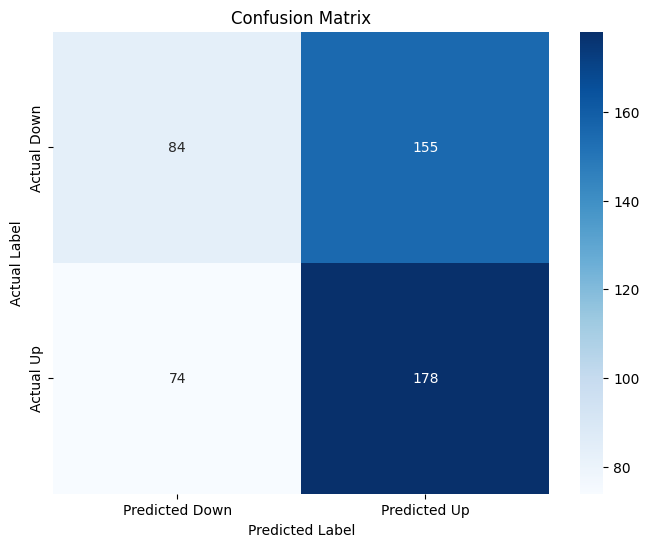

In [ ]:

y_pred = model.predict(X_test)




accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Set: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down (0)', 'Up (1)']))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Down', 'Predicted Up'],
            yticklabels=['Actual Down', 'Actual Up'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

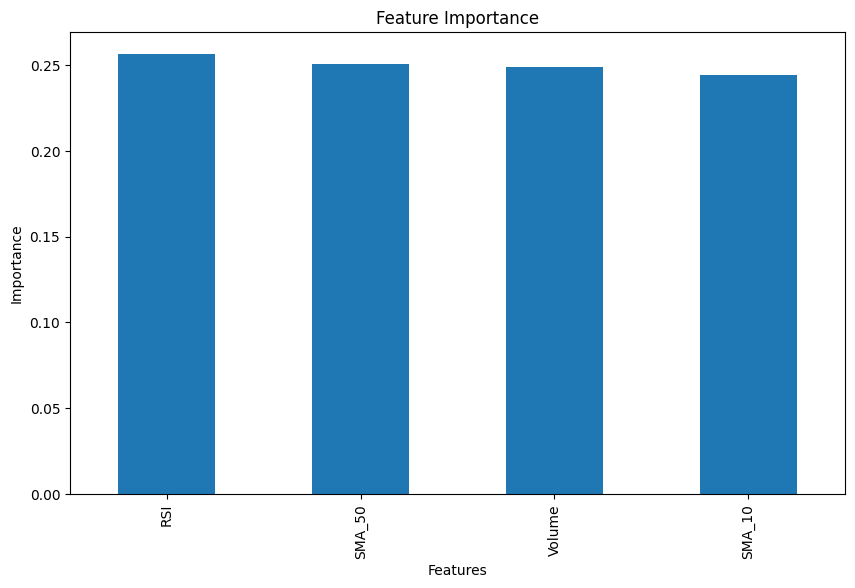

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [ ]:

last_row = df[features].tail(1)

prediction = model.predict(last_row)
probability = model.predict_proba(last_row)

print(f"\nThe last available data is for the date: {last_row.index[0].date()}")
print(f"Features for prediction: \n{last_row.to_string()}")

if prediction[0] == 1:
    print(f"\n---> Model Prediction for the next trading day: UP")
else:
    print(f"\n---> Model Prediction for the next trading day: DOWN")

print(f"Prediction Confidence: {probability[0][prediction[0]]:.2%}")


The last available data is for the date: 2021-04-29
Features for prediction: 
             SMA_10    SMA_50        RSI   Volume
Date                                             
2021-04-29  3142.09  3104.813  35.805836  1621395

---> Model Prediction for the next trading day: DOWN
Prediction Confidence: 57.00%


In [ ]:

final_df = df.merge(results_df, left_index=True, right_index=True, how='inner')


powerbi_df = final_df[['Close', 'Volume_x', 'SMA_10_x', 'SMA_50_x', 'RSI_x', 
                       'Actual_Direction', 'Predicted_Direction', 'Correct_Prediction']]


powerbi_df = powerbi_df.rename(columns={
    'Close': 'Closing_Price',
    'Volume_x': 'Volume',
    'SMA_10_y': 'SMA_10',
    'SMA_50_y': 'SMA_50',
    'RSI_x': 'RSI'
})

powerbi_df.to_csv('TCS_Prediction_Results.csv')

print("✅ Success! The file 'TCS_Prediction_Results.csv' has been saved with the correct columns.")

✅ Success! The file 'TCS_Prediction_Results.csv' has been saved with the correct columns.
